In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [ ]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./MIR/genres/{g}'):
        songname = f'./MIR/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./MIR/genres/{g}'):
        songname = f'./MIR/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [2]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596748,121.557297,-19.158825,...,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,blues
1,blues.00001.wav,0.340983,0.095918,1529.835316,2038.617579,3548.820207,0.056044,-207.556793,124.006721,8.930560,...,5.376803,-2.239120,4.216963,-6.012273,0.936109,-0.716537,0.293876,-0.287431,0.531573,blues
2,blues.00002.wav,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754387,140.459900,-29.109968,...,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,blues
3,blues.00003.wav,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431152,150.099213,5.647593,...,6.087676,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,blues
4,blues.00004.wav,0.308590,0.091563,1835.494603,1748.362448,3580.945013,0.101500,-160.266037,126.198807,-35.605450,...,-2.806383,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703781,blues


In [3]:
data.shape

(1000, 28)

In [4]:
data = data.drop(['filename'],axis=1)

In [5]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

In [9]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128,validation_data=(X_test, y_test),)

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 395us/step - loss: 2.1988 - accuracy: 0.2300 - val_loss: 1.9859 - val_accuracy: 0.3050
Epoch 2/20
800/800 [==============================] - 0s 35us/step - loss: 1.8659 - accuracy: 0.3625 - val_loss: 1.7895 - val_accuracy: 0.3400
Epoch 3/20
800/800 [==============================] - 0s 26us/step - loss: 1.6416 - accuracy: 0.4363 - val_loss: 1.6293 - val_accuracy: 0.4350
Epoch 4/20
800/800 [==============================] - 0s 25us/step - loss: 1.4436 - accuracy: 0.5125 - val_loss: 1.4943 - val_accuracy: 0.4800
Epoch 5/20
800/800 [==============================] - 0s 24us/step - loss: 1.3071 - accuracy: 0.5362 - val_loss: 1.4099 - val_accuracy: 0.5200
Epoch 6/20
800/800 [==============================] - 0s 25us/step - loss: 1.1830 - accuracy: 0.6012 - val_loss: 1.3335 - val_accuracy: 0.5600
Epoch 7/20
800/800 [==============================] - 0s 26us/step - loss: 1.0956 - accuracy: 0

In [11]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


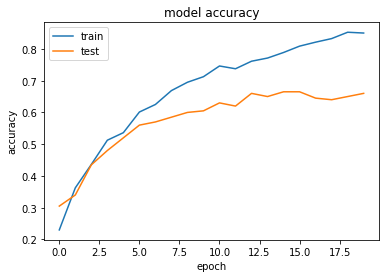

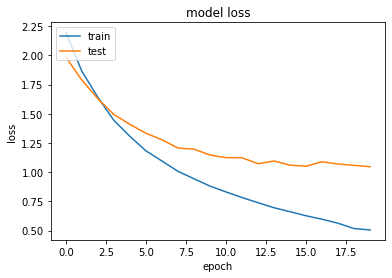

In [12]:
 # Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

    # Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
cnn_test = model.evaluate(X_test,y_test)[1]
cnn_train = model.evaluate(X_train,y_train)[1]
cnn_test

800/800 [==============================] - 0s 23us/step


0.6600000262260437

In [14]:
print('test_acc: ',test_acc)

NameError: name 'test_acc' is not defined

In [ ]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer

import tensorflow as tf
import tensorflow_probability as tfp


class DenseVariational(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=0.75,
                 prior_sigma_2=0.002,
                 prior_pi=1, **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.init_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)

        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input
from keras.models import Model

batch_size = 64
num_batches = 1000 / batch_size

kl_weight = 1.0 / num_batches
prior_params = {
    'prior_sigma_1': 0.75,
    'prior_sigma_2': 0.002,
    'prior_pi': 1 
}

x_in = Input(shape=(26,))
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(10,kl_weight, **prior_params, activation='softmax')(x)

model2 = Model(x_in, x)

In [ ]:
from keras import callbacks, optimizers

noise = 1

def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model2.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.08), metrics=['mse','accuracy'])
history2 = model2.fit(X_train, y_train, batch_size=32, epochs=20,
                        validation_data=(X_test, y_test), verbose=1)

In [ ]:
print(model2.evaluate(X_train, y_train))

In [ ]:
print(history2.history.keys())

In [ ]:
 # Summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

    # Summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[0.305, 0.415, 0.475, 0.5, 0.56, 0.575, 0.62, 0.605, 0.64, 0.6, 0.63, 0.625]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


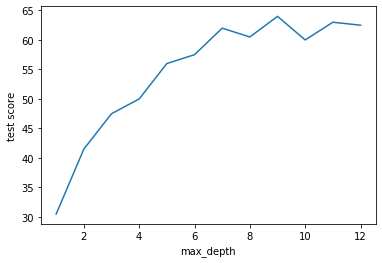

In [15]:
from sklearn.ensemble import RandomForestClassifier

test_score=[]
max_depth=1
depths=[]
for max_depth in range(1,13):
    clf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=1)
    clf.fit(X_train, y_train)
    test_score.append(clf.score(X_test, y_test))
    depths.append(max_depth)
print(test_score);
print(depths);
test_score = np.array(test_score)
rfc_train=clf.score(X_train,y_train)
rfc_test = clf.score(X_test,y_test)

plt.plot(depths, test_score*100)
plt.xlabel('max_depth')
plt.ylabel('test score')
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

random_state=10;
multi_class='multinomial';
solver='lbfgs';
max_iter=1000;

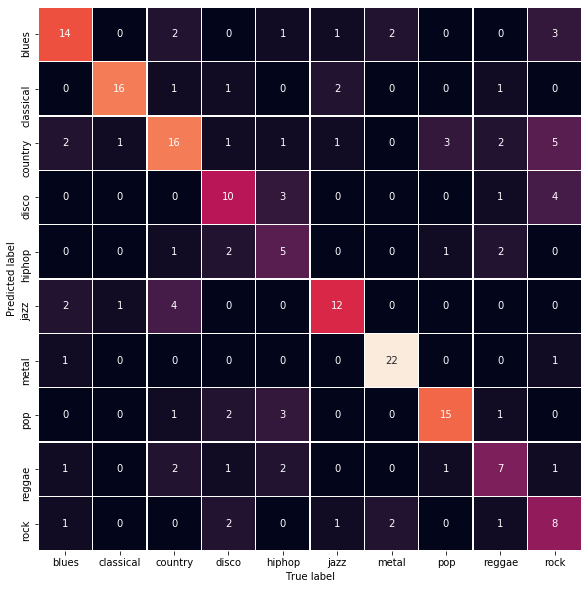

In [23]:
from sklearn.linear_model import LogisticRegression
genresDict = {'blues':1, 'classical':2, 'country':3, 'disco':4, 'hiphop':5, 'jazz':6, 'metal':7, 'pop':7,
 'reggae':8, 'rock':9}
lr = LogisticRegression(random_state=10,multi_class='multinomial',solver='newton-cg',max_iter=100).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred
mat = confusion_matrix(y_test, y_pred)
figMat = plt.subplots(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=genresDict.keys(),
            yticklabels=genresDict.keys(), linewidths=.5)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [24]:
print((np.unique(genre_list)))

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [25]:
lr_test = lr.score(X_test,y_test)
print(lr_test)

0.615


In [26]:
lr_train = lr.score(X_train,y_train)
print(lr_train)

0.70375


In [ ]:
print("trdt")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms

#imports from our lib
from blitz.modules import BayesianLinear
from blitz.losses import kl_divergence_from_nn
from blitz.utils import variational_estimator
from blitz.utils.minibatch_weighting import minibatch_weight


X_train, y_train = torch.tensor(X_train,dtype=torch.float), torch.tensor(y_train, dtype=torch.float)
X_test, y_test = torch.tensor(X_test,dtype=torch.float), torch.tensor(y_test, dtype=torch.float)


ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=100, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=100, shuffle=True)

#create dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=100, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=100, shuffle=True)

#lets just create our bnn class
@variational_estimator
class BayesianNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, 512)
        self.blinear2 = BayesianLinear(512,128)
        self.blinear3 = BayesianLinear(128, output_dim)
       
    def forward(self, x):
        x_ = x.view(-1, 26)
        x_ = self.blinear1(x_)
        x_ = self.blinear2(x_)
        return self.blinear3(x_)

device = torch.device('cpu')
classifier = BayesianNetwork(26, 10).to(device)
optimizer = optim.SGD(classifier.parameters(), lr=0.08)
criterion = torch.nn.NLLLoss()


iteration = 0
for epoch in range(5):
    for i, (datapoints, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        pi_weight = minibatch_weight(batch_idx=i, num_batches=32)
        labels = labels.to(device=device, dtype=torch.int64)
        loss = classifier.sample_elbo(
            inputs=datapoints.to(device),
            labels=labels.to(device),
            criterion=criterion,
            sample_nbr=3,
            complexity_cost_weight=pi_weight
        )
        

        optimizer.step()
       
        iteration += 1
        if iteration%1000==0:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_loader:
                    images, labels = data
                    outputs = classifier(images.to(device))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels.to(device)).sum().item()
                print('Iteration: {} | Accuracy of the network on the 10000 test images: {} %'.format(str(iteration) ,str(100 * correct / total)))


In [21]:
from sklearn.svm import SVC

decision_function_shape='ovo'

svc = SVC(decision_function_shape=decision_function_shape)
svc.fit(X_train, y_train)

svc_train = svc.score(X_train, y_train)
print(svc_train);

svc_test = svc.score(X_test, y_test)
print(svc_test);

0.805
0.675


[[0.8650000095367432, 0.70375, 1.0, 0.805], [0.6600000262260437, 0.615, 0.625, 0.675]]


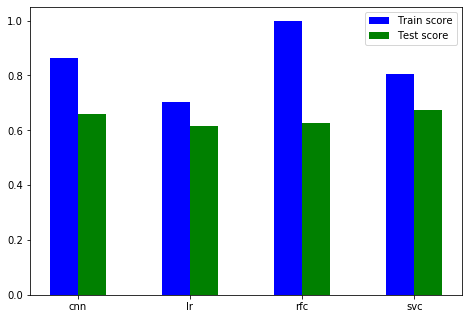

In [22]:
data = [[cnn_train, lr_train, rfc_train, svc_train],
[cnn_test, lr_test, rfc_test, svc_test]]
print(data)
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
width=0.25
ax.bar(X + 0.00, data[0], color = 'b', width = width, label='Train score')
ax.bar(X + 0.25, data[1], color = 'g', width = width, label='Test score')
plt.xticks(X + 0.125, ('cnn','lr', 'rfc', 'svc'))
ax.legend()